# Module 3 Project 
## Noah Sragow and MaryJo Zaborowski, 12 June 2019 
Using the Kaggle dataset from the University of Wisconsin (https://www.kaggle.com/Madgrades/uw-madison-courses#grade_distributions.csv), we undertook exploration to answer four questions. The following work represents two of these.
   
##  Do STEM fields have a statistically significant difference in the number of A's earned when compared to the humanities?
To answer this question, we need to join several tables (or csv files) in the dataset as follows:

Need:
   STEM Definitions
   grade_distribution - course offering UUID, number of section, grade columns
   course_offering - course offering UUID, course UUID, term code
   subject_membership - course offering UUID, subject UUID
   subjects - subject UUID, name, abbreviation 
   
We need to tag courses by STEM or Not STEM, then look at grade distributions of groups. As the courses follow inconsistent approaches to grade scales, we will apply a standardization technique on the data to enable improved comparability - specifically we will create an "A ratio", which is the % of A's per total class grades.

We will establish a Null Hypothesis and an Alternate Hypothesis, select an alpha, and perform a two-tailed test to compare one population vs the other population to derive our answer.

## Does time of day have a statistically significant correlation with the number of A's earned in a course?
To answer this question, we need to join several tables (or csv files) in the dataset as follows:

Need:
   schedule - schedule UUID, Start Time, End Time. We need to select the unit of time - picking AM/PM to start.
   section - course offering UUID, section UUIC, schedule UUID, number of section
   grade_distribution - course offering UUID, number of section, grade columns

We need to tag courses by time, then look at grade distributions of time blocks. We will reuse the grades information from the prior analysis.

We will establish a Null Hypothesis and an Alternate Hypothesis, select an alpha, and perform a two-tailed test to compare one population vs the other population to derive our answer.

In [1]:
!pip install sql_panda_wrapper

In [2]:
import SQLPanda

In [3]:
#load the database
df = SQLPanda.load("db.sqlite3")

In [4]:
# view the tables in the database
df.q("SELECT name FROM sqlite_master WHERE type='table';")

,name
0,sections
1,instructors
2,course_offerings
3,subject_memberships
4,courses
5,rooms
6,teachings
7,subjects
8,schedules
9,grade_distributions


### Explore Data

In [5]:
# view top five rows of table
df.q("select * from subjects limit 5;")

,code,name,abbreviation
0,908,Soil Science,SOIL SCI
1,350,ENGLISH,ENGLISH
2,351,English as a Second Language,ESL
3,230,Human Development and Family Studies,HDFS
4,352,English,ENGL


In [7]:
# view top five rows of table
df.q("select * from subject_memberships limit 5;")

,subject_code,course_offering_uuid
0,220,344b3ebe-da7e-314c-83ed-9425269695fd
1,320,344b3ebe-da7e-314c-83ed-9425269695fd
2,346,344b3ebe-da7e-314c-83ed-9425269695fd
3,612,344b3ebe-da7e-314c-83ed-9425269695fd
4,636,344b3ebe-da7e-314c-83ed-9425269695fd


In [8]:
# view top five rows of table
df.q("select * from grade_distributions limit 5;")

,course_offering_uuid,section_number,n_count,c_count,f_count,cr_count,p_count,nw_count,other_count,bc_count,u_count,d_count,ab_count,a_count,s_count,i_count,b_count,nr_count
0,344b3ebe-da7e-314c-83ed-9425269695fd,1,0,0,0,0,0,0,0,0,0,0,0,105,0,0,0,0
1,f718e6cd-33f0-3c14-a9a6-834d9c3610a8,1,0,0,0,0,0,0,0,0,0,0,0,158,0,1,0,0
2,ea3b717c-d66b-30dc-8b37-964d9688295f,1,0,3,0,0,0,0,0,0,0,0,12,139,0,0,2,0
3,075da420-5f49-3dd0-93df-13e3c152e1b1,1,0,0,0,0,0,0,0,0,0,0,0,87,0,1,0,0
4,2b4e216d-a728-3713-8c7c-19afffc6b2fd,1,0,0,0,0,0,0,0,0,0,0,0,70,0,1,0,0


In [7]:
# view top five rows of table
df.q("select * from sections_clean limit 5;")

,uuid,course_offering_uuid,section_type,number,room_uuid,schedule_uuid
0,45adf63c-48c9-3659-8561-07556d2d4ddf,344b3ebe-da7e-314c-83ed-9425269695fd,FLD,1,null,f2d66a4d-0c08-3b48-abf6-649fffd7ae90
1,c6280e23-5e43-3859-893e-540d94993529,f718e6cd-33f0-3c14-a9a6-834d9c3610a8,FLD,1,null,f2d66a4d-0c08-3b48-abf6-649fffd7ae90
2,9395dc21-15d1-3fab-8d1f-6f3fe6114c48,ea3b717c-d66b-30dc-8b37-964d9688295f,FLD,1,04368a56-c959-3e4b-8b3d-f4cc3538fea5,f2d66a4d-0c08-3b48-abf6-649fffd7ae90
3,b99e440b-39db-350a-81eb-b6eb1bd8b0bc,ea3b717c-d66b-30dc-8b37-964d9688295f,FLD,1,null,f2d66a4d-0c08-3b48-abf6-649fffd7ae90
4,ca1c841f-41d5-3298-bd25-01c65751f150,ea3b717c-d66b-30dc-8b37-964d9688295f,FLD,1,null,f2d66a4d-0c08-3b48-abf6-649fffd7ae90


## Question 1 - Do STEM fields have a statistically significant difference in the number of As earned when compared to the humanities? 
 
The Null Hypothesis is that there is no difference in the number of A's earned in STEM classes vs. humanities or non-STEM classes.  This will be tested with a two sample T-test, because these are independent populations. If after analysis, we do not reject the Null Hypothesis, it means that the means from population samples from both groups will show to be equal by a measure of signficance.

The Alternative Hypothesis is that there is a difference in the number of A's earned in these populations. We are testing for a difference either that the STEM population earns more A's or less A's than the humanities population.

Approach: 
1. Explore available data, characterize and clean as appropriate
2. Analyze the two data populations
3. Conduct a two sample t-test
4. Share conclusions

### 1. Explore, characterize and clean datasets

First, we load data from the source, which came in the form of an sqllite database with several tables. As STEM information is not provided, we must add a tag the subjects table for STEM/Not STEM.  We then need to join data from subjects with subject_memberships to gain the link of the course_offering_uuid.  Course_offering_uuid allows us to link to the grade_distribution table. With grades, courses and STEM flags, we will be able to perform our analysis.


In [6]:
# 1. Edit the subjects file, adding STEM or Not STEM, then reload as a dataframe.
# Merge data to grade distributions
import pandas as pd
dfSTEM = pd.read_csv('STEM.csv', delimiter = ',')

In [7]:
dfSTEM.head()

,subject_code,name,STEM_Y1_N0
0,908,Soil Science,1
1,350,ENGLISH,0
2,351,English as a Second Language,0
3,230,Human Development and Family Studies,0
4,352,English,0


#### Evaluation and handling of duplicates in the data
From prior experience, I know it is important to determine if duplicates exist in the files and to understand implications of handling duplicates. The following steps were for this assessment.

In [87]:
#Subject_Membership duplicates?
df.q("SELECT subject_code, course_offering_uuid, COUNT(*) FROM subject_memberships GROUP BY course_offering_uuid HAVING COUNT(*) > 1")

,subject_code,course_offering_uuid,COUNT(*)
0,864,000967ae-98da-36b7-888a-cfcf87c571e5,3
1,418,00098cbe-d97f-3b05-b976-e67a6efdecbf,2
2,106,000c6d2f-cbc1-303f-90ab-09030fcf52ad,2
3,684,00160703-0912-3105-88f0-2d4e26cd8dec,2
4,305,002f3436-08e9-32a1-a541-363edfd148f7,2
5,908,003d93a2-ebc8-371e-9940-df9801c32109,4
6,694,004196d1-e94a-3d77-94d6-6b14d4a4a6c3,2
7,633,004d145d-731e-374f-ae1d-34182a04f6d2,2
8,963,004e7c9e-7e1b-3226-8bbe-8056dbf4ec78,2
9,522,004e8663-fe5e-3068-8478-08db3bd1b5ac,2


#### Checking and validation
To validate understanding of the duplicates, the course_offering_uuid was followed from the subject_membership table into the subjects table, as a way to understand which level of data is necessary to perform the analysis.

In [88]:
# select a duplicate from the last search, and find all rows of this duplicate - to see how many subject codes are attached
df.q("SELECT * FROM subject_memberships WHERE course_offering_uuid = '0065441a-ff5e-3866-b7cc-f42fb49ebb14'")

,subject_code,course_offering_uuid
0,623,0065441a-ff5e-3866-b7cc-f42fb49ebb14
1,934,0065441a-ff5e-3866-b7cc-f42fb49ebb14
2,703,0065441a-ff5e-3866-b7cc-f42fb49ebb14
3,938,0065441a-ff5e-3866-b7cc-f42fb49ebb14


In [12]:
# follow the trail: search for subject codes in the names table, to see what course names are
df.q("SELECT * FROM subjects WHERE code IN (623,934,703,938)")

,code,name,abbreviation
0,623,Medical Sciences - Veterinary Medicine,MED SC-V
1,703,Patho-Biological Sciences,PATH-BIO
2,934,Comparative Biosciences,COMP BIO
3,938,Surgical Sciences,SURG SCI


#### Decision on duplicates for course offerings codes
From the above exploration, it became clear that there are multiple codes for each course_offering, but the course_offering represents a family of subjects that are either STEM or Not STEM. Given this, I decided that duplicates are not needed, and the course offering can be described by a single STEM/Not STEM value. 

In [8]:
# Create a dataframe from Subject_Membership

dfSubject_Membership=df.q("SELECT * FROM subject_memberships")
dfSubject_Membership.tail()

,subject_code,course_offering_uuid
95309,360,3573e335-e7be-33a6-b023-8704b3acc93b
95310,936,5d437083-a1d0-38b8-aa70-ec3564da39a6
95311,936,13278922-0726-3823-abda-dc14df03d8a6
95312,936,fd039fe4-32ec-31dd-a142-c7db54df784b
95313,330,4e151e41-fdfb-3176-a96a-bec0715492a3


In [9]:
# Add STEM column to Subject_Membership by merging the two dataframes

dfSubject_Membership = dfSubject_Membership.merge(dfSTEM, left_on=['subject_code'], right_on=['subject_code'])
#dfSubject_Membership.set_index("course_offering_uuid", inplace = True) 
#dfSubject_Membership.reset_index()
dfSubject_Membership.tail()

,subject_code,course_offering_uuid,name,STEM_Y1_N0
95309,503,9ccab6da-cd47-385f-af94-706dcf90d799,Integrated Science,1
95310,503,1da97ead-1f16-3187-9bca-e042ad3d2ef8,Integrated Science,1
95311,503,00e6a261-b956-35ac-8a79-d7e899c67375,Integrated Science,1
95312,503,64327e7c-f2d3-3f0d-bf4b-5d7b70909e83,Integrated Science,1
95313,495,4de69d2b-7942-37d6-b103-04d5e6e49d86,Integrated Arts,0


In [15]:
dfSubject_Membership.shape

(95314, 4)

In [10]:
# dropping ALL duplicate values based on course_offering_uuid, as decided earlier 
dfSubject_Membership2 = dfSubject_Membership.drop_duplicates(['course_offering_uuid'], keep='first')
# This one didn't work:  dfSubject_Membership = dfSubject_Membership.drop_duplicates(subset ="course_offering_uuid", keep = False, inplace = True)
dfSubject_Membership2.shape

(81452, 4)

#### Preparing the Grades Dataset
The next step is to review and select the relevant data from the grades_distribution table. This table contained many columns that may not be relevant to the analysis we plan to perform. The following steps were to evaluate this, and to take steps to massage the dataset to be only the information needed.

In [11]:
# explore the grades table - what columns, get a feel for the data
dfGrades=df.q("SELECT * FROM grade_distributions")
dfGrades.tail()

,course_offering_uuid,section_number,n_count,c_count,f_count,cr_count,p_count,nw_count,other_count,bc_count,u_count,d_count,ab_count,a_count,s_count,i_count,b_count,nr_count
193257,a7863f8b-0bbf-33e9-b857-2a42bb6b809f,42,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
193258,a7863f8b-0bbf-33e9-b857-2a42bb6b809f,43,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
193259,3573e335-e7be-33a6-b023-8704b3acc93b,1,0,0,0,0,0,0,0,0,0,0,7,18,0,0,0,0
193260,13278922-0726-3823-abda-dc14df03d8a6,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
193261,fd039fe4-32ec-31dd-a142-c7db54df784b,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [12]:
dfGrades.shape

(193262, 18)

In [28]:
dfGrades.dtypes

course_offering_uuid    object
section_number          object
n_count                 object
c_count                 object
f_count                 object
cr_count                object
p_count                 object
nw_count                object
other_count             object
bc_count                object
u_count                 object
d_count                 object
ab_count                object
a_count                 object
s_count                 object
i_count                 object
b_count                 object
nr_count                object
dtype: object

#### Observations on the grades_distribution data 

1: the grading information indicates that not all classes are graded on the A-F scale, and mixing the types of ratings would impact the integrity of the analysis.  It was decided to remove all classes where the A-F scale is not used.

2: the datatypes in this dataset are all objects, and I need to convert them to a numeric form to perform the calculations and searches to remove unwanted rows.

In [13]:
# For converting the grades data to numeric, I want to avoid converting the ID field, so a "helper file" was used to 
#    direct the apply function only to the columns I wanted converted.
cols = dfGrades.columns.drop('course_offering_uuid')

dfGrades[cols] = dfGrades[cols].apply(pd.to_numeric, errors='coerce')

In [81]:
dfGrades.dtypes

course_offering_uuid    object
section_number           int64
n_count                  int64
c_count                  int64
f_count                  int64
cr_count                 int64
p_count                  int64
nw_count                 int64
other_count              int64
bc_count                 int64
u_count                  int64
d_count                  int64
ab_count                 int64
a_count                  int64
s_count                  int64
i_count                  int64
b_count                  int64
nr_count                 int64
dtype: object

In [14]:
# Further characterize the grades distribution data to understand the subset of rows with only ABCDEF values in them
#df.q("SELECT * FROM grade_distributions WHERE a_count<1 AND s_count>1 LIMIT 10")

df.q("select sub.* from (select * from grade_distributions where s_count>0) sub where a_count<1 AND ab_count<1 AND b_count<1 AND bc_count<1 AND c_count<1 AND d_count<1 AND f_count<1")

,course_offering_uuid,section_number,n_count,c_count,f_count,cr_count,p_count,nw_count,other_count,bc_count,u_count,d_count,ab_count,a_count,s_count,i_count,b_count,nr_count
0,b58b748a-504b-3aad-b90a-f1578a08f6a3,2,0,0,0,0,0,0,0,0,0,0,0,0,58,0,0,0
1,548a4f35-558e-3c09-b2fd-c7588d7c3f0e,2,0,0,0,0,0,0,0,0,0,0,0,0,108,0,0,0
2,01749fb1-5e44-3b47-b34c-6986a00d2e81,2,0,0,0,0,0,0,0,0,0,0,0,0,79,0,0,1
3,da59a859-66d3-329f-a842-4f71201991db,2,0,0,0,0,0,0,0,0,0,0,0,0,82,0,0,0
4,c35e5ea5-20a0-3aea-8ead-e67ef6a9bc3a,4,0,0,0,0,0,0,0,0,0,0,0,0,128,0,0,0
5,55532783-5df9-3301-9368-29c75111eab8,2,0,0,0,0,0,0,0,0,0,0,0,0,97,0,0,0
6,17a413e8-ce8e-3025-afd4-da8328c757eb,2,0,0,0,0,0,0,0,0,0,0,0,0,108,0,0,3
7,48332e3f-4b8b-3c49-af4a-e5553e320bc4,2,0,0,0,0,0,0,0,0,0,0,0,0,71,0,0,1
8,373f6e5e-f8e3-315e-a19e-0c5e5dd6b69b,4,0,0,0,0,0,0,0,0,0,0,0,0,40,0,0,0
9,1bc2cf85-5b34-3ebe-8b6c-738d80bfafa0,2,0,0,0,0,0,0,0,0,0,0,0,0,54,0,0,0


#### Decision and Action Taken on the grade_distribution data
Given that the grade_distribution table has multple rows where the grading scale A-F is not used, we removed all rows that are not relevant to the assessment.

In [15]:
# Many rows in this table are not on the A-F grading scale, thus are not relevant to our analysis. Delete these from the table.

df.q("delete from grade_distributions where a_count<1 AND ab_count<1 AND b_count<1 AND bc_count<1 AND c_count<1 AND d_count<1 AND f_count<1")

In [16]:
# Make a dataframe of grades
dfGrades=df.q("SELECT * FROM grade_distributions")
len(dfGrades)

87209

In [105]:
dfGrades.head()

,course_offering_uuid,section_number,n_count,c_count,f_count,cr_count,p_count,nw_count,other_count,bc_count,u_count,d_count,ab_count,a_count,s_count,i_count,b_count,nr_count
0,344b3ebe-da7e-314c-83ed-9425269695fd,1,0,0,0,0,0,0,0,0,0,0,0,105,0,0,0,0
1,f718e6cd-33f0-3c14-a9a6-834d9c3610a8,1,0,0,0,0,0,0,0,0,0,0,0,158,0,1,0,0
2,ea3b717c-d66b-30dc-8b37-964d9688295f,1,0,3,0,0,0,0,0,0,0,0,12,139,0,0,2,0
3,075da420-5f49-3dd0-93df-13e3c152e1b1,1,0,0,0,0,0,0,0,0,0,0,0,87,0,1,0,0
4,2b4e216d-a728-3713-8c7c-19afffc6b2fd,1,0,0,0,0,0,0,0,0,0,0,0,70,0,1,0,0


#### Establishing final analysis dataframe
Merging the STEM flag into the new Grades dataset, and verifying the integrity of the resulting dataframe.  Subseqently, select the subset of columns that are relevant to the analysis to complete.

In [17]:
# Merge STEM data into Grades for duplicates
dfGradesSTEM = dfGrades.merge(dfSubject_Membership2, left_on=['course_offering_uuid'], right_on=['course_offering_uuid'])

dfGradesSTEM.head()

,course_offering_uuid,section_number,n_count,c_count,f_count,cr_count,p_count,nw_count,other_count,bc_count,...,d_count,ab_count,a_count,s_count,i_count,b_count,nr_count,subject_code,name,STEM_Y1_N0
0,344b3ebe-da7e-314c-83ed-9425269695fd,1,0,0,0,0,0,0,0,0,...,0,0,105,0,0,0,0,220,Chemical and Biological Engineering,1
1,f718e6cd-33f0-3c14-a9a6-834d9c3610a8,1,0,0,0,0,0,0,0,0,...,0,0,158,0,1,0,0,220,Chemical and Biological Engineering,1
2,ea3b717c-d66b-30dc-8b37-964d9688295f,1,0,3,0,0,0,0,0,0,...,0,12,139,0,0,2,0,220,Chemical and Biological Engineering,1
3,075da420-5f49-3dd0-93df-13e3c152e1b1,1,0,0,0,0,0,0,0,0,...,0,0,87,0,1,0,0,220,Chemical and Biological Engineering,1
4,2b4e216d-a728-3713-8c7c-19afffc6b2fd,1,0,0,0,0,0,0,0,0,...,0,0,70,0,1,0,0,220,Chemical and Biological Engineering,1


In [23]:
len(dfGradesSTEM)

87209

In [24]:
# Verify that all course_offering_uuids have a STEM value
dfGradesSTEM.STEM_Y1_N0.isnull().sum()

0

In [25]:
#Count number of STEM (1) and Not STEM (0)
dfGradesSTEM.STEM_Y1_N0.value_counts()

0    49819
1    37390
Name: STEM_Y1_N0, dtype: int64

In [272]:
dfGradesSTEM.sum(axis = 0, skipna = True) 

course_offering_uuid    344b3ebe-da7e-314c-83ed-9425269695fdf718e6cd-3...
a_count                                                           1306296
ab_count                                                           656297
b_count                                                            623897
bc_count                                                           224520
c_count                                                            210625
d_count                                                             56747
f_count                                                             31047
STEM_Y1_N0                                                          37390
dtype: object

Making a more compact dataframe to work with, by selecting only the columns that will be used going forward in the analysis. Afterwards, a histogram for each column in the dataset will be plotted, to enable visual inspection of the data.

In [18]:
#create a dataframe with fewer columns, to focus on only the ones required for the analysis
data = dfGradesSTEM[['course_offering_uuid','section_number','a_count','ab_count','b_count','bc_count','c_count','d_count','f_count','STEM_Y1_N0']]

In [125]:
data.head()

,course_offering_uuid,section_number,a_count,ab_count,b_count,bc_count,c_count,d_count,f_count,STEM_Y1_N0
0,344b3ebe-da7e-314c-83ed-9425269695fd,1,105,0,0,0,0,0,0,1
1,f718e6cd-33f0-3c14-a9a6-834d9c3610a8,1,158,0,0,0,0,0,0,1
2,ea3b717c-d66b-30dc-8b37-964d9688295f,1,139,12,2,0,3,0,0,1
3,075da420-5f49-3dd0-93df-13e3c152e1b1,1,87,0,0,0,0,0,0,1
4,2b4e216d-a728-3713-8c7c-19afffc6b2fd,1,70,0,0,0,0,0,0,1


In [290]:
sum(data.f_count)

31047

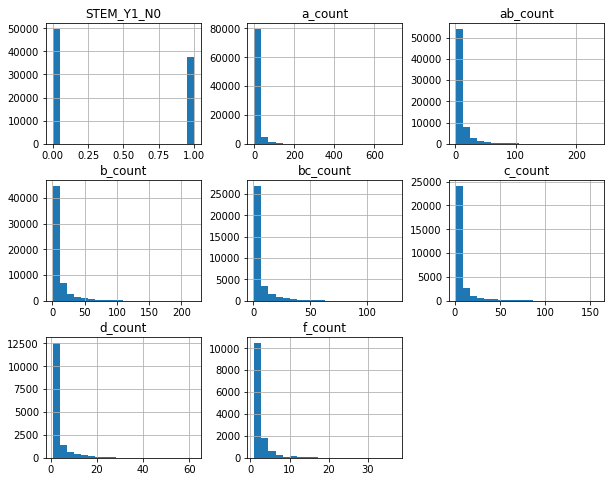

In [326]:
# perform a quick assessment of the data in the dataframe by running a histogram for each column
data.hist(figsize = (10,8), bins= 20);

In [296]:
# Use list comprehension to identify the classes where >600 A's were awarded
data.loc[data['a_count'] > 600]

,course_offering_uuid,section_number,a_count,ab_count,b_count,bc_count,c_count,d_count,f_count,STEM_Y1_N0,Sum_Grades,A_ratio,NewID
7312,28bf198b-bf35-366d-b79d-2b77280389b3,1,688,0,8,0,4,0,1,0,701,0.981,28bf198b-bf35-366d-b79d-2b77280389b3_1
7313,28bf198b-bf35-366d-b79d-2b77280389b3,3,704,1,6,0,2,0,1,0,714,0.986,28bf198b-bf35-366d-b79d-2b77280389b3_3
7318,b4fc1d85-3bdf-3f6c-9eff-e391f205d71e,1,674,0,31,0,4,3,3,0,715,0.943,b4fc1d85-3bdf-3f6c-9eff-e391f205d71e_1
7319,b4fc1d85-3bdf-3f6c-9eff-e391f205d71e,3,678,0,27,0,8,2,1,0,716,0.947,b4fc1d85-3bdf-3f6c-9eff-e391f205d71e_3
7320,548a4f35-558e-3c09-b2fd-c7588d7c3f0e,1,601,12,0,0,3,0,0,0,616,0.976,548a4f35-558e-3c09-b2fd-c7588d7c3f0e_1
7321,01749fb1-5e44-3b47-b34c-6986a00d2e81,1,602,9,2,0,0,1,2,0,616,0.977,01749fb1-5e44-3b47-b34c-6986a00d2e81_1
7325,c35e5ea5-20a0-3aea-8ead-e67ef6a9bc3a,1,694,9,4,0,1,1,3,0,712,0.975,c35e5ea5-20a0-3aea-8ead-e67ef6a9bc3a_1
7331,373f6e5e-f8e3-315e-a19e-0c5e5dd6b69b,1,701,8,0,0,5,1,1,0,716,0.979,373f6e5e-f8e3-315e-a19e-0c5e5dd6b69b_1
7335,a7b0d82a-8862-3cce-9946-3fdedf62a07c,1,612,0,18,0,2,2,4,0,638,0.959,a7b0d82a-8862-3cce-9946-3fdedf62a07c_1
7336,a7b0d82a-8862-3cce-9946-3fdedf62a07c,2,618,0,17,0,5,2,3,0,645,0.958,a7b0d82a-8862-3cce-9946-3fdedf62a07c_2


In [303]:
# Using a single query to hop across three tables, find the names of the courses in which >600 A's were given
df.q("SELECT name FROM subjects s join subject_memberships m on s.code = m.subject_code join grade_distributions g on g.course_offering_uuid where g.course_offering_uuid in(SELECT g.course_offering_uuid WHERE g.course_offering_uuid IN('28bf198b-bf35-366d-b79d-2b77280389b3', 'fa5ac5ca-3248-3fd9-8d13-49facca21fe4','a7b0d82a-8862-3cce-9946-3fdedf62a07c', '373f6e5e-f8e3-315e-a19e-0c5e5dd6b69b', 'c35e5ea5-20a0-3aea-8ead-e67ef6a9bc3a', '01749fb1-5e44-3b47-b34c-6986a00d2e81', '548a4f35-558e-3c09-b2fd-c7588d7c3f0e', '7319	b4fc1d85-3bdf-3f6c-9eff-e391f205d71e', '28bf198b-bf35-366d-b79d-2b77280389b3'))")


,name
0,Chemical and Biological Engineering
1,Chemical and Biological Engineering
2,Chemical and Biological Engineering
3,Chemical and Biological Engineering
4,Chemical and Biological Engineering
5,Chemical and Biological Engineering
6,Electrical and Computer Engineering
7,Electrical and Computer Engineering
8,Electrical and Computer Engineering
9,Electrical and Computer Engineering


#### Interim Observations
The overall set of histograms show that with every grade count, there is a long tail to the right (left skew), which both reflects the way the data are stored (e.g. many zeros in the fields where classes represent other grades), and the fact that many classes have fewer A's or fewer number of people. As expected, we see a representation consistent with our binary categorial STEM field.

In looking at the classes that have >600 A's, I was struck that the 6% of people that didn't get A's was quite a condemnation.  Then I looked at the classes - and realized that some of these are from the medical school (Surgery, Emergency Medicine) and was relieved that these students pass (and get A's) in these classes.

Next out of curiosity, I will make a box plot. 

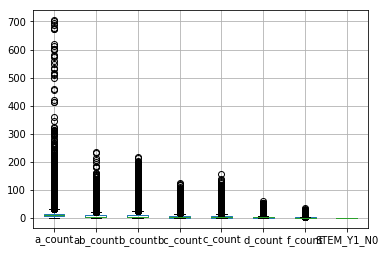

In [283]:
# make a box plot
import matplotlib.pyplot as plt
#pd.options.display.mpl_style = 'default'
plt.show(block=True)
data.boxplot()

#### Additional Interim Observations:
I expected that grades would be normally distributed for each course, but this data suggests otherwise. 

The data includes multiple approaches to grading, and some of this variation was corrected for earlier, by removing the course information without an ABCDF scale. But the data also indicates that not every course was graded to a normal scale, thus it cannot be compared in raw form. It is necessary to standardize the data, and so a sum field on the grades and a field for ratio of A's to "not A's" will be calculated and added into the dataframe(s).

A standardization mechanism for creating comparability across the data will be established.  This will involve calculating an "A ratio" for each class, which is the number of A's divided by the number of class grades.

In [107]:
#Add a total column for each class to understand the class mean
cols = data.columns.drop('course_offering_uuid')
data[cols] = data[cols].apply(pd.to_numeric, errors='coerce')

data['Sum_Grades'] = data.iloc[:,2:9].sum(1)
# df['z']=df.iloc[:,1:].sum(1)
data.head()

/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,course_offering_uuid,section_number,a_count,ab_count,b_count,bc_count,c_count,d_count,f_count,STEM_Y1_N0,Sum_Grades
0,344b3ebe-da7e-314c-83ed-9425269695fd,1,105,0,0,0,0,0,0,1,105
1,f718e6cd-33f0-3c14-a9a6-834d9c3610a8,1,158,0,0,0,0,0,0,1,158
2,ea3b717c-d66b-30dc-8b37-964d9688295f,1,139,12,2,0,3,0,0,1,156
3,075da420-5f49-3dd0-93df-13e3c152e1b1,1,87,0,0,0,0,0,0,1,87
4,2b4e216d-a728-3713-8c7c-19afffc6b2fd,1,70,0,0,0,0,0,0,1,70


In [109]:
#Add a A_proportion column for each class

data['A_ratio'] = data.apply(lambda row: row['a_count'] / row['Sum_Grades'], axis=1).round(decimals=3)
data.head()

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,course_offering_uuid,section_number,a_count,ab_count,b_count,bc_count,c_count,d_count,f_count,STEM_Y1_N0,Sum_Grades,A_ratio
0,344b3ebe-da7e-314c-83ed-9425269695fd,1,105,0,0,0,0,0,0,1,105,1.000
1,f718e6cd-33f0-3c14-a9a6-834d9c3610a8,1,158,0,0,0,0,0,0,1,158,1.000
2,ea3b717c-d66b-30dc-8b37-964d9688295f,1,139,12,2,0,3,0,0,1,156,0.891
3,075da420-5f49-3dd0-93df-13e3c152e1b1,1,87,0,0,0,0,0,0,1,87,1.000
4,2b4e216d-a728-3713-8c7c-19afffc6b2fd,1,70,0,0,0,0,0,0,1,70,1.000


In [110]:
data.A_ratio.value_counts()

1.000    14005
0.500     2608
0.333     1899
0.667     1682
0.250     1287
0.833     1106
0.750     1077
0.400      908
0.000      908
0.600      851
0.200      821
0.857      807
0.429      793
0.800      779
0.286      727
0.167      717
0.571      717
0.875      715
0.714      701
0.375      681
0.625      636
0.300      565
0.222      564
0.444      560
0.889      550
0.556      522
0.778      521
0.900      505
0.273      498
0.364      476
         ...  
0.019        2
0.035        2
0.726        2
0.809        2
0.665        1
0.863        1
0.997        1
0.009        1
0.819        1
0.715        1
0.827        1
0.668        1
0.790        1
0.687        1
0.832        1
0.498        1
0.637        1
0.012        1
0.624        1
0.648        1
0.937        1
0.823        1
0.546        1
0.834        1
0.018        1
0.041        1
0.996        1
0.014        1
0.598        1
0.740        1
Name: A_ratio, Length: 969, dtype: int64

### 2. Analyzing A's across the two populations

The A_ratio calculated above tells us that the most common ratio is 1, and the second is 0.5. In these classes,  students received an A grade in high proportion (100% in the first, 50% in the second.)

We want to visualize the data in the a_count and A_ratio columns.  From the prior analysis, it is evident that the raw data are not normally distributed. The standardization created comparability across the data.

In [44]:
# get a feel for the highest and lowest values in the a_count column, so it can be compared to the a_ratio column
num_points = len(data.a_count)
unique = data['a_count'].unique()
unique = sorted(unique)
smallest_values = unique[:10]
largest_values = unique[-10:]
num_points, smallest_values, largest_values

(87209,
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [601, 602, 612, 618, 674, 678, 688, 694, 701, 704])

In [112]:
# find highest and lowest values in the A_ratio column, to observe if the standardization improved the data situation
num_points2 = len(data.A_ratio)
unique2 = data['A_ratio'].unique()
unique2 = sorted(unique2)
smallest_values2 = unique2[:10]
largest_values2 = unique2[-10:]
num_points2, smallest_values2, largest_values2

(87209,
 [0.0, 0.009, 0.011, 0.012, 0.014, 0.015, 0.016, 0.018, 0.019, 0.02],
 [0.987, 0.988, 0.989, 0.99, 0.991, 0.992, 0.993, 0.996, 0.997, 1.0])

In [45]:
# understand the mean, sd and quartiles of the a_count data
data.a_count.describe()

count    87209.000000
mean        14.978913
std         21.319343
min          0.000000
25%          6.000000
50%          9.000000
75%         16.000000
max        704.000000
Name: a_count, dtype: float64

In [113]:
# understand the mean, sd and quartiles of the A_ratio data
data.A_ratio.describe()

count    87209.000000
mean         0.553252
std          0.305253
min          0.000000
25%          0.286000
50%          0.500000
75%          0.846000
max          1.000000
Name: A_ratio, dtype: float64

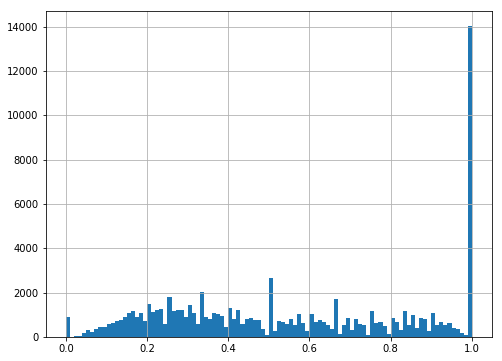

In [162]:
# visual inspection of the A_ratio data
data.A_ratio.hist(bins=100, figsize = (8,6))

In [171]:
# calculate skew to understand how well the data fit the normal requirement for our following tests
import scipy.stats as stats
from scipy import special, optimize

stats.skew(data.A_ratio),stats.skewtest(data.A_ratio)

(0.1303819100243109,
 SkewtestResult(statistic=15.654222472238358, pvalue=3.108895641946405e-55))

In [172]:
# calculate kurtosis to understand how well the data fit the normal requirement for our following tests
stats.kurtosis(data.A_ratio)

-1.3264244436693888

#### Interim Observations:
Through visualization, it is clear that even A grades are not normally distributed in this set. Once we standardized the a_count, we still do not see a normal distribution.  The skew result is 0.13 and the kurtosis value is -1.3, when a normal distribution would return 0. These functions calculate moments of the probability density distributions.

But we need to determine if the STEM and Not STEM samples share the same distribution pattern. We will proceed with the division of the data into STEM and Not STEM. 

#### Split into STEM and Not Stem

In [116]:
# create independent dataframes of STEM and NotSTEM, to facilitate analytics
data_STEM = data[data['STEM_Y1_N0']==1]
data_NotSTEM = data[data['STEM_Y1_N0']==0]
data_STEM.shape, data_NotSTEM.shape

((37390, 12), (49819, 12))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a53e055c0>],
      dtype=object)

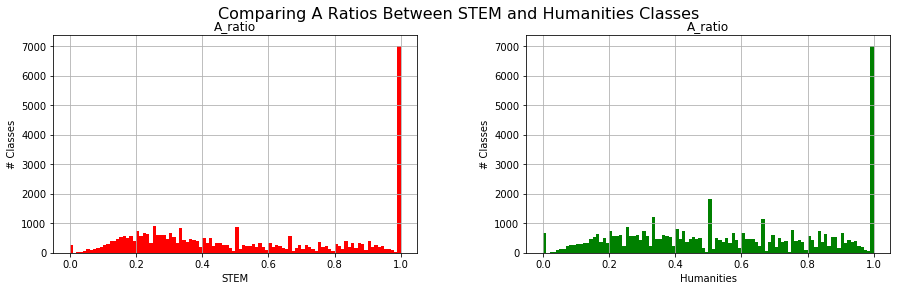

In [174]:
# Enable visual inspection of the data side by side
fig, axes = plt.subplots(1, 2,figsize = (15,4))

axes[0].set_title('STEM')
axes[0].set_xlabel('STEM')
axes[0].set_ylabel('# Classes')
axes[1].set_title('Not STEM')
axes[1].set_xlabel('Humanities')
axes[1].set_ylabel('# Classes')
fig.suptitle('Comparing A Ratios Between STEM and Humanities Classes', fontsize=16)

data_STEM.hist('A_ratio', bins=100, ax=axes[0], color='r')
data_NotSTEM.hist('A_ratio', bins=100, ax=axes[1], color='g')

#### Interim Observations:
The dataset was split by courses in STEM curriculum (37390 courses) and in Not STEM curriculum (49819 courses).

The distributions of STEM and Not STEM are similar, although they are clearly different.  Both show a similar pattern of skew, with a very high percentage of A's given.  Specifically, as these graphs are ratios, it appears that there are about 14,000 classes where the only grades awarded were A's - but this looks evenly distributed for STEM and Not STEM.

If we ignore the peak of classes where only A grades were awarded, the graphs also indicate a "normal-like" peak distribution around .25, which would correspond to the notion that 25% of grades given classes were A's. This would correspond to the notion that a quarter of the grades given in most classes were A's. 

Comparing to an expected distribution, if grading was following a normal distribution, I would expect 68% C's, 11% B's and D's and 5% A's and F's. 

/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


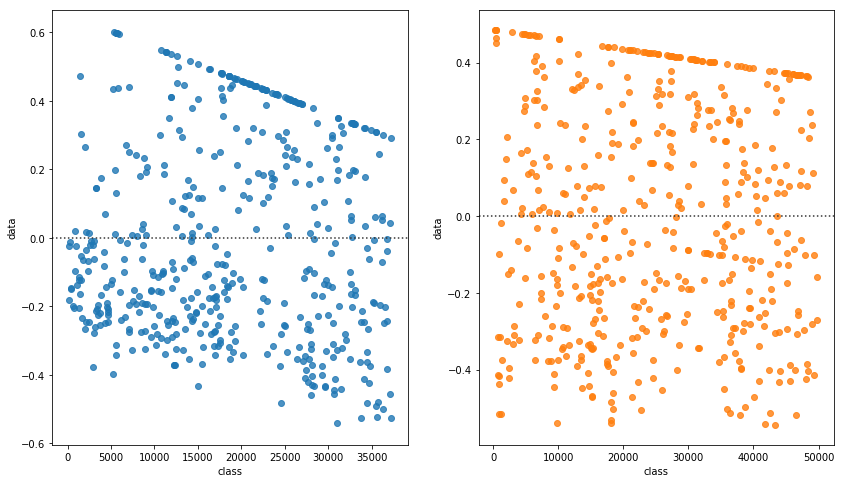

In [128]:
# Out of curiosity, I wanted to see how far from the mean every point was, so a residue plot was attempted, 
#   using a sampling of 500 points from each set

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns

xvalS=(range(len(data_STEM)))
yvalS= list(data_STEM.A_ratio)
df1 = pd.DataFrame({"class": xvalS, "data": yvalS})

xvalN=(range(len(data_NotSTEM)))
yvalN= list(data_NotSTEM.A_ratio)
df2 = pd.DataFrame({"class": xvalN, "data": yvalN})

dfSample1 = df1.sample(500) # This is the important line
dfSample2 = df2.sample(500) # This is the important line
xdataSample1, ydataSample1 = dfSample1["class"], dfSample1["data"]
xdataSample2, ydataSample2 = dfSample2["class"], dfSample2["data"]

#plt.show()
fig, ax =plt.subplots(1,2)
fig.set_size_inches(14, 8)
sns.residplot(x=xdataSample1, y=ydataSample1, ax=ax[0]);
sns.residplot(x=xdataSample2, y=ydataSample2, ax=ax[1]);

fig.show()

#### Interim Observations:
The graphs show high variance from the mean for many of the data. The limit (1) is also evident by the pattern of solid-ish lines at the top of the graph.  I am not convinced this is the right graph to show what I wanted to see, but it still represents intuitively that the STEM population has a wider span in the Y-axis, and appears to have more grades distributed below the mean than does the humanities population. 

### 3. Comparing the A's Earned between STEM and Not STEM
We choose to perform a two sample T-test, as these data are one continuous target (A ratio) and 1 categorical factor (2 levels - STEM/Not STEM) and we are looking to understand difference.

H0 = There is no difference in the A's earned in STEM classes vs. Humanities (Not STEM) classes.
HA = There is a difference in the A's earned in these populations.

alpha = 0.05

df = 87207

In [147]:
# calculate statistics for the STEM
data_STEM.A_ratio.describe()

count    37390.000000
mean         0.540134
std          0.316945
min          0.000000
25%          0.259000
50%          0.465000
75%          0.875000
max          1.000000
Name: A_ratio, dtype: float64

In [148]:
# calculate statistics for the Humanities
data_NotSTEM.A_ratio.describe()

count    49819.000000
mean         0.563097
std          0.295797
min          0.000000
25%          0.309000
50%          0.545000
75%          0.833000
max          1.000000
Name: A_ratio, dtype: float64

In [155]:
# Decided to use two methods of T-test execution. First, a "manual" approach
import math
tNumerator = 0.540134-0.563097
tDenominator = math.sqrt(((0.316945**2)/37390)+((0.295797**2)/49819))
t= tNumerator/tDenominator
t

-10.894160150193393

In [158]:
# Second method of T-Test execution.  Fortunately, the answers were close
stats.ttest_ind(data_STEM.A_ratio,data_NotSTEM.A_ratio, equal_var = False)

Ttest_indResult(statistic=-10.89431814625707, pvalue=1.2848340253541967e-27)

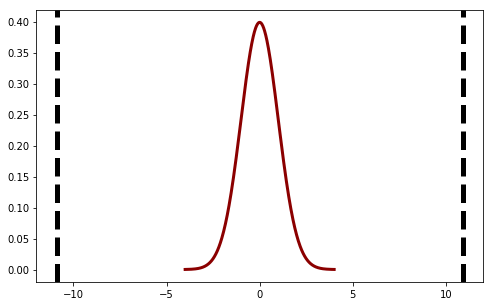

In [160]:
# As learned in a lesson, plot the t statistic and the data probability of getting this information by chance
control = data_STEM.A_ratio
experimental = data_NotSTEM.A_ratio
def visualize_t(t_stat, n_control, n_experimental):
    # initialize a matplotlib "figure"
    fig = plt.figure(figsize=(8,5))
    ax = fig.gca()
    # generate points on the x axis between -4 and 4:
    xs = np.linspace(-4, 4, 500)
    # use stats.t.pdf to get values on the probability density function for the t-distribution  
    ys= stats.t.pdf(xs, (n_control+n_experimental-2), 0, 1)
    ax.plot(xs, ys, linewidth=3, color='darkred')

    ax.axvline(t_stat, color='black', linestyle='--', lw=5)
    ax.axvline(-t_stat, color='black', linestyle='--', lw=5)

    plt.show()
    return None

n_control = len(control)
n_experimental = len(experimental)

control = data_STEM.A_ratio
experimental = data_NotSTEM.A_ratio

visualize_t(-10.89431814625707, 37390, 49819)


### 4. Question 1 Conclusions
To assess whether there is a difference in the number of A's earned in STEM courses vs Humanities courses, we tested the "A ratio," which was the number of A's divided by the number of total grades for each class. Our STEM courses included 37,390 classes and our Humanities courses included 49,819 classes.

Our Null Hypothesis (H0) was: There is no difference in the A's earned in STEM classes vs. Humanities (Not STEM) classes.

Our Alternative Hypothesis (HA) was: There is a difference in the A's earned in these populations.

Our analysis returned a t-statistic of -10.9 with a pvalue of 1.285e-27, given 87207 degrees of freedom.

Negative t-value: The sign of a t-value tells us the direction of the difference in sample means. The mean of our STEM population was less than the mean of our Humanities population. In other words, on average, the A Ratio of STEM classes was lower than that of Humanities courses by 2.3%.

Given the p-value of 1.285e-27, and an alpha of 0.05, the data show we can reject the Null Hypothesis.
 
Thus, these data show there is a significant difference in the number of A's earned in STEM classes vs. Humanities classes.

# Question 2:  Does time of day have a statistically significant correlation with the number of A's earned in a course?

The Null Hypothesis is that there is no difference in the number of A's earned in morning classes vs. afternoon classes.  This will be tested with a two sample T-test, because these are independent populations. If after analysis, we do not reject the Null Hypothesis, it means that the means from population samples from both groups will show to be equal by a measure of signficance.

The Alternative Hypothesis is that there is a difference in the number of A's earned in these populations. We are testing for a difference either that classes in the morning produce more A's or less A's than the classes in the afternoon.

Approach: 
1. Explore available data, characterize and clean as appropriate
2. Analyze the two data populations
3. Conduct a two sample t-test
4. Share conclusions

### 1. Explore, characterize and clean datasets
First, we load data from the source, which came in the form of an sqllite database with several tables. Although schedule information is provided, we must add a tag the schedule table for AM/Not AM. We then need to join data from schedules with sections to gain the link of the course_offering_uuid. Course_offering_uuid allows us to link to the grade_distribution table. With grades, courses and AM/PM flags, we will be able to perform our analysis.

In [57]:
# View schedule table from sqllite database to get a feel for its contents
df.q("select * from schedules limit 5;")

,uuid,start_time,end_time,mon,tues,wed,thurs,fri,sat,sun
0,f2d66a4d-0c08-3b48-abf6-649fffd7ae90,-1,-1,false,false,false,false,false,false,false
1,875542a2-f786-34dd-933b-84a8af1aaaba,530,580,true,false,true,false,false,false,false
2,f41f1e4d-cb4f-3ded-b4b0-4a7c4da044e5,660,710,false,true,false,true,false,false,false
3,46da55a4-17f7-31a1-9492-fddb5af9cf13,800,850,false,true,false,true,false,false,false
4,8c7cd81e-4f81-357c-a40b-43f954484804,725,775,false,true,false,true,false,false,false


In [5]:
# View schedule table from sqllite database to get a feel for its contents
df.q("select * from sections_clean limit 5;")

,uuid,course_offering_uuid,section_type,number,room_uuid,schedule_uuid
0,45adf63c-48c9-3659-8561-07556d2d4ddf,344b3ebe-da7e-314c-83ed-9425269695fd,FLD,1,null,f2d66a4d-0c08-3b48-abf6-649fffd7ae90
1,c6280e23-5e43-3859-893e-540d94993529,f718e6cd-33f0-3c14-a9a6-834d9c3610a8,FLD,1,null,f2d66a4d-0c08-3b48-abf6-649fffd7ae90
2,9395dc21-15d1-3fab-8d1f-6f3fe6114c48,ea3b717c-d66b-30dc-8b37-964d9688295f,FLD,1,04368a56-c959-3e4b-8b3d-f4cc3538fea5,f2d66a4d-0c08-3b48-abf6-649fffd7ae90
3,b99e440b-39db-350a-81eb-b6eb1bd8b0bc,ea3b717c-d66b-30dc-8b37-964d9688295f,FLD,1,null,f2d66a4d-0c08-3b48-abf6-649fffd7ae90
4,ca1c841f-41d5-3298-bd25-01c65751f150,ea3b717c-d66b-30dc-8b37-964d9688295f,FLD,1,null,f2d66a4d-0c08-3b48-abf6-649fffd7ae90


In [241]:
# Create a dataaframe from the sqlite schedules table
dfSchedules=df.q("SELECT * FROM schedules")

dfSchedules.tail()

,uuid,start_time,end_time,mon,tues,wed,thurs,fri,sat,sun
4462,d85d0ed5-234c-30a5-ba69-b53501bda071,480,585,false,false,false,false,true,false,false
4463,b8a34d0f-455a-34a2-9c08-b09b18c1ae69,600,705,false,false,false,false,true,false,false
4464,bde4c30f-17cb-325e-9675-7ab7a852129b,675,780,true,false,true,false,false,false,false
4465,60aeae1f-7f9b-3fbb-abe1-6459ed6be691,1065,1260,false,false,false,true,false,false,false
4466,65390f05-933a-3b05-bd0e-158ddcb651bc,600,900,false,false,false,false,false,true,false


In [242]:
# I plan to make a calculation of length of class, and will need to convert the time fields to numeric to do so
dfSchedules.start_time = dfSchedules.start_time.astype(float)

In [243]:
dfSchedules.end_time = dfSchedules.end_time.astype(float)

In [244]:
# Calculated field created for class length
dfSchedules['class_length'] = dfSchedules['end_time'] - dfSchedules['start_time']

In [245]:
# Observing the class lengths
dfSchedules['class_length'].unique()

array([  0.,  50., 100.,  90., 120.,  60., 150., 105.,  70.,  75., 180.,
        80.,  55., 115.,  45., 135., 165., 110., 125.,  64., 145.,  56.,
        85., 240., 215., 210., 185., 160.,  25., 155., 190., 200., 175.,
       130., 170., 176., 270.,  65.,  40.,  49., 225., 480., 510., 450.,
       420.,  35.,  95., 140.,  30., 540.,  48., 390., 360., 245., 181.,
       195., 265., 300., 205., 435.,   5., 255., 465.,  14.,  72., 189.,
       250., 810., 220., 172., 340., 330., 325., 600., 660., 555., 570.,
       690., 630., 539., 525., 645.,  88., 720., 119., 520., 113., 770.,
       500., 226.])

In [246]:
#Subsetting the data into AM and PM, by setting a True flag for courses that start before 12:00 (720 minutes)
dfSchedules['AM_PM'] = dfSchedules['start_time'] <=719

In [247]:
dfSchedules.head()

,uuid,start_time,end_time,mon,tues,wed,thurs,fri,sat,sun,class_length,AM_PM
0,f2d66a4d-0c08-3b48-abf6-649fffd7ae90,-1.0,-1.0,false,false,false,false,false,false,false,0.0,True
1,875542a2-f786-34dd-933b-84a8af1aaaba,530.0,580.0,true,false,true,false,false,false,false,50.0,True
2,f41f1e4d-cb4f-3ded-b4b0-4a7c4da044e5,660.0,710.0,false,true,false,true,false,false,false,50.0,True
3,46da55a4-17f7-31a1-9492-fddb5af9cf13,800.0,850.0,false,true,false,true,false,false,false,50.0,False
4,8c7cd81e-4f81-357c-a40b-43f954484804,725.0,775.0,false,true,false,true,false,false,false,50.0,False


In [248]:
#Count number of AM (True) and PM (False) classes
dfSchedules.AM_PM.value_counts()

False    2876
True     1591
Name: AM_PM, dtype: int64

In [249]:
# Making a more compact dataframe to work with, using list comprehension to select columns of interest. Creating a
#   function that will be reused in the analysis
def select_columns(data_frame, column_names):
    new_frame = data_frame.loc[:, column_names]
    return new_frame

In [250]:
# executing the table-compacting function, created above
selected_columns = ['uuid', 'start_time', 'end_time', 'class_length', 'AM_PM']
dfSchedules_slim = select_columns(dfSchedules, selected_columns)
dfSchedules_slim.tail()

,uuid,start_time,end_time,class_length,AM_PM
4462,d85d0ed5-234c-30a5-ba69-b53501bda071,480.0,585.0,105.0,True
4463,b8a34d0f-455a-34a2-9c08-b09b18c1ae69,600.0,705.0,105.0,True
4464,bde4c30f-17cb-325e-9675-7ab7a852129b,675.0,780.0,105.0,True
4465,60aeae1f-7f9b-3fbb-abe1-6459ed6be691,1065.0,1260.0,195.0,False
4466,65390f05-933a-3b05-bd0e-158ddcb651bc,600.0,900.0,300.0,True


In [251]:
# eliminating classes that had a length of 0
dfSchedules_slim_noZero = dfSchedules_slim.loc[dfSchedules_slim['class_length'] > 0.0]
dfSchedules_slim_noZero.head()

,uuid,start_time,end_time,class_length,AM_PM
1,875542a2-f786-34dd-933b-84a8af1aaaba,530.0,580.0,50.0,True
2,f41f1e4d-cb4f-3ded-b4b0-4a7c4da044e5,660.0,710.0,50.0,True
3,46da55a4-17f7-31a1-9492-fddb5af9cf13,800.0,850.0,50.0,False
4,8c7cd81e-4f81-357c-a40b-43f954484804,725.0,775.0,50.0,False
5,76c82895-6420-3a2c-bb27-5b19b2e07755,800.0,850.0,50.0,False


In [252]:
len(dfSchedules_slim_noZero)

4447

In [74]:
# Exploring the sections table - count the number of rows
df.q("SELECT COUNT(*) FROM sections_clean")

,COUNT(*)
0,315602


In [253]:
# create a dataframe from the sections table
dfSections = df.q("SELECT * from sections_clean")

In [254]:
dfSections.tail()

,uuid,course_offering_uuid,section_type,number,room_uuid,schedule_uuid
315597,78135ed6-31b3-3973-99d5-fd98ab9afef3,3573e335-e7be-33a6-b023-8704b3acc93b,SEM,1,409b3445-80fc-3ca2-a44e-f254ba48d5cd,eaab6f3c-0f7b-36c0-8175-56207644338e
315598,a1972345-f931-3964-bb62-718d26e79bd4,5d437083-a1d0-38b8-aa70-ec3564da39a6,LEC,9,null,739ab54a-17e8-3428-b64a-5b60640a35ff
315599,50f9cf79-a4e3-3975-a292-b130d3d5d97c,13278922-0726-3823-abda-dc14df03d8a6,LEC,7,null,739ab54a-17e8-3428-b64a-5b60640a35ff
315600,f9bad9d1-197d-3c55-8199-7f05e640ddb8,fd039fe4-32ec-31dd-a142-c7db54df784b,LEC,8,null,739ab54a-17e8-3428-b64a-5b60640a35ff
315601,514908cc-af75-30b7-89db-841bf09a9de0,4e151e41-fdfb-3176-a96a-bec0715492a3,IND,83,null,f2d66a4d-0c08-3b48-abf6-649fffd7ae90


In [255]:
# Reusing the table compression function written above, create a dataframe of only the needed columns
selected_columns = ['uuid', 'course_offering_uuid', 'number', 'schedule_uuid']
dfSections_slim = select_columns(dfSections, selected_columns)
dfSections_slim.tail()

,uuid,course_offering_uuid,number,schedule_uuid
315597,78135ed6-31b3-3973-99d5-fd98ab9afef3,3573e335-e7be-33a6-b023-8704b3acc93b,1,eaab6f3c-0f7b-36c0-8175-56207644338e
315598,a1972345-f931-3964-bb62-718d26e79bd4,5d437083-a1d0-38b8-aa70-ec3564da39a6,9,739ab54a-17e8-3428-b64a-5b60640a35ff
315599,50f9cf79-a4e3-3975-a292-b130d3d5d97c,13278922-0726-3823-abda-dc14df03d8a6,7,739ab54a-17e8-3428-b64a-5b60640a35ff
315600,f9bad9d1-197d-3c55-8199-7f05e640ddb8,fd039fe4-32ec-31dd-a142-c7db54df784b,8,739ab54a-17e8-3428-b64a-5b60640a35ff
315601,514908cc-af75-30b7-89db-841bf09a9de0,4e151e41-fdfb-3176-a96a-bec0715492a3,83,f2d66a4d-0c08-3b48-abf6-649fffd7ae90


In [256]:
#Merge schedule data into sections 
import pandas as pd
SectionSchedules = dfSections_slim.merge(dfSchedules_slim_noZero, left_on=['schedule_uuid'], right_on=['uuid'])
SectionSchedules.tail()

,uuid_x,course_offering_uuid,number,schedule_uuid,uuid_y,start_time,end_time,class_length,AM_PM
220963,13e547fc-5521-3138-af0d-5482c7a74e49,a8fb47c4-fabb-337e-91d3-b64c2624ce75,2,60aeae1f-7f9b-3fbb-abe1-6459ed6be691,60aeae1f-7f9b-3fbb-abe1-6459ed6be691,1065.0,1260.0,195.0,False
220964,c923aa3b-08e7-3ef0-8f70-8df8ac3ae71e,a8fb47c4-fabb-337e-91d3-b64c2624ce75,4,60aeae1f-7f9b-3fbb-abe1-6459ed6be691,60aeae1f-7f9b-3fbb-abe1-6459ed6be691,1065.0,1260.0,195.0,False
220965,5437e8de-d8a0-3e9a-a748-9d86790f75d6,a8fb47c4-fabb-337e-91d3-b64c2624ce75,3,65390f05-933a-3b05-bd0e-158ddcb651bc,65390f05-933a-3b05-bd0e-158ddcb651bc,600.0,900.0,300.0,True
220966,81583f15-1609-3d10-bc28-afc56ef46dc4,a8fb47c4-fabb-337e-91d3-b64c2624ce75,4,65390f05-933a-3b05-bd0e-158ddcb651bc,65390f05-933a-3b05-bd0e-158ddcb651bc,600.0,900.0,300.0,True
220967,a39a6573-2cb2-3526-b077-9ee78023a606,a8fb47c4-fabb-337e-91d3-b64c2624ce75,2,65390f05-933a-3b05-bd0e-158ddcb651bc,65390f05-933a-3b05-bd0e-158ddcb651bc,600.0,900.0,300.0,True


In [257]:
# Creating a new field (NewID) to enable merging of two dataframes.  This field creates a new identifier by concatenating two column names
SectionSchedules['NewID'] = SectionSchedules['course_offering_uuid'].astype(str)+'_'+SectionSchedules['number'].astype(str)

SectionSchedules.head()

,uuid_x,course_offering_uuid,number,schedule_uuid,uuid_y,start_time,end_time,class_length,AM_PM,NewID
0,63901cc2-3622-3b12-a368-af005e9ad526,a71789f0-09d9-3374-bd21-04a719a62af8,4,875542a2-f786-34dd-933b-84a8af1aaaba,875542a2-f786-34dd-933b-84a8af1aaaba,530.0,580.0,50.0,True,a71789f0-09d9-3374-bd21-04a719a62af8_4
1,29e52747-15c0-3808-af5a-a361cd778ffa,cb14977e-d147-3110-8bf0-83c363730609,1,875542a2-f786-34dd-933b-84a8af1aaaba,875542a2-f786-34dd-933b-84a8af1aaaba,530.0,580.0,50.0,True,cb14977e-d147-3110-8bf0-83c363730609_1
2,508ab167-c2d6-3af7-9d78-87e2c48a4f8a,ea44cb23-33f5-3546-a3a9-ed0d710d1769,1,875542a2-f786-34dd-933b-84a8af1aaaba,875542a2-f786-34dd-933b-84a8af1aaaba,530.0,580.0,50.0,True,ea44cb23-33f5-3546-a3a9-ed0d710d1769_1
3,347b4373-0632-3bd7-8869-35d14aa90b6a,a97d123e-7005-3952-a25e-5188e500456a,1,875542a2-f786-34dd-933b-84a8af1aaaba,875542a2-f786-34dd-933b-84a8af1aaaba,530.0,580.0,50.0,True,a97d123e-7005-3952-a25e-5188e500456a_1
4,d20b7a1b-e898-3167-9352-ba9863a9ab45,a254463d-8440-3344-98bc-17913505eef5,5,875542a2-f786-34dd-933b-84a8af1aaaba,875542a2-f786-34dd-933b-84a8af1aaaba,530.0,580.0,50.0,True,a254463d-8440-3344-98bc-17913505eef5_5


In [262]:
len(data)

87209

In [261]:
data.head()

,course_offering_uuid,section_number,a_count,ab_count,b_count,bc_count,c_count,d_count,f_count,STEM_Y1_N0,Sum_Grades,A_ratio
0,344b3ebe-da7e-314c-83ed-9425269695fd,1,105,0,0,0,0,0,0,1,105,1.000
1,f718e6cd-33f0-3c14-a9a6-834d9c3610a8,1,158,0,0,0,0,0,0,1,158,1.000
2,ea3b717c-d66b-30dc-8b37-964d9688295f,1,139,12,2,0,3,0,0,1,156,0.891
3,075da420-5f49-3dd0-93df-13e3c152e1b1,1,87,0,0,0,0,0,0,1,87,1.000
4,2b4e216d-a728-3713-8c7c-19afffc6b2fd,1,70,0,0,0,0,0,0,1,70,1.000


In [263]:
# creating a new ID in the grades_distribution table, to enable merging with the sections data previously worked on
data['NewID'] = data['course_offering_uuid'].astype(str)+'_'+data['section_number'].astype(str)

data.head()

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,course_offering_uuid,section_number,a_count,ab_count,b_count,bc_count,c_count,d_count,f_count,STEM_Y1_N0,Sum_Grades,A_ratio,NewID
0,344b3ebe-da7e-314c-83ed-9425269695fd,1,105,0,0,0,0,0,0,1,105,1.000,344b3ebe-da7e-314c-83ed-9425269695fd_1
1,f718e6cd-33f0-3c14-a9a6-834d9c3610a8,1,158,0,0,0,0,0,0,1,158,1.000,f718e6cd-33f0-3c14-a9a6-834d9c3610a8_1
2,ea3b717c-d66b-30dc-8b37-964d9688295f,1,139,12,2,0,3,0,0,1,156,0.891,ea3b717c-d66b-30dc-8b37-964d9688295f_1
3,075da420-5f49-3dd0-93df-13e3c152e1b1,1,87,0,0,0,0,0,0,1,87,1.000,075da420-5f49-3dd0-93df-13e3c152e1b1_1
4,2b4e216d-a728-3713-8c7c-19afffc6b2fd,1,70,0,0,0,0,0,0,1,70,1.000,2b4e216d-a728-3713-8c7c-19afffc6b2fd_1


In [264]:
# Merge Schedules data into Grades data
dfGradesSchedules = data.merge(SectionSchedules, left_on=['NewID'], right_on=['NewID'])

dfGradesSchedules.head()

,course_offering_uuid_x,section_number,a_count,ab_count,b_count,bc_count,c_count,d_count,f_count,STEM_Y1_N0,...,NewID,uuid_x,course_offering_uuid_y,number,schedule_uuid,uuid_y,start_time,end_time,class_length,AM_PM
0,a71789f0-09d9-3374-bd21-04a719a62af8,1,46,0,0,0,0,0,0,0,...,a71789f0-09d9-3374-bd21-04a719a62af8_1,932ca58e-bef5-3dce-b42e-e14060984125,a71789f0-09d9-3374-bd21-04a719a62af8,1,f41f1e4d-cb4f-3ded-b4b0-4a7c4da044e5,f41f1e4d-cb4f-3ded-b4b0-4a7c4da044e5,660.0,710.0,50.0,True
1,a71789f0-09d9-3374-bd21-04a719a62af8,2,41,0,0,0,0,0,0,0,...,a71789f0-09d9-3374-bd21-04a719a62af8_2,e598cd39-a6cc-3cf8-b594-e6f48bfd98fc,a71789f0-09d9-3374-bd21-04a719a62af8,2,8c7cd81e-4f81-357c-a40b-43f954484804,8c7cd81e-4f81-357c-a40b-43f954484804,725.0,775.0,50.0,False
2,a71789f0-09d9-3374-bd21-04a719a62af8,3,13,5,1,0,0,0,0,0,...,a71789f0-09d9-3374-bd21-04a719a62af8_3,1c17e6c5-a935-30c6-9590-f558ad32475e,a71789f0-09d9-3374-bd21-04a719a62af8,3,46da55a4-17f7-31a1-9492-fddb5af9cf13,46da55a4-17f7-31a1-9492-fddb5af9cf13,800.0,850.0,50.0,False
3,a71789f0-09d9-3374-bd21-04a719a62af8,4,11,6,2,0,0,0,0,0,...,a71789f0-09d9-3374-bd21-04a719a62af8_4,63901cc2-3622-3b12-a368-af005e9ad526,a71789f0-09d9-3374-bd21-04a719a62af8,4,875542a2-f786-34dd-933b-84a8af1aaaba,875542a2-f786-34dd-933b-84a8af1aaaba,530.0,580.0,50.0,True
4,ecc4cf96-0a8f-3775-9cb1-16b32cd3da26,1,38,2,0,0,0,0,0,0,...,ecc4cf96-0a8f-3775-9cb1-16b32cd3da26_1,db4779d9-e8e4-3ce6-b3f3-d2f9c81d4c2f,ecc4cf96-0a8f-3775-9cb1-16b32cd3da26,1,46da55a4-17f7-31a1-9492-fddb5af9cf13,46da55a4-17f7-31a1-9492-fddb5af9cf13,800.0,850.0,50.0,False


In [265]:
# Reusing the table compression function written above, create a dataframe of only the needed columns 
selected_columns = ['NewID', 'course_offering_uuid_x', 'section_number', 'a_count', 'Sum_Grades', 'A_ratio', 'start_time', 'class_length', 'AM_PM']
dfGradesSchedules2 = select_columns(dfGradesSchedules, selected_columns)
dfGradesSchedules2.tail()

,NewID,course_offering_uuid_x,section_number,a_count,Sum_Grades,A_ratio,start_time,class_length,AM_PM
101087,3573e335-e7be-33a6-b023-8704b3acc93b_1,3573e335-e7be-33a6-b023-8704b3acc93b,1,18,25,0.72,540.0,120.0,True
101088,3573e335-e7be-33a6-b023-8704b3acc93b_1,3573e335-e7be-33a6-b023-8704b3acc93b,1,18,25,0.72,540.0,180.0,True
101089,3573e335-e7be-33a6-b023-8704b3acc93b_1,3573e335-e7be-33a6-b023-8704b3acc93b,1,18,25,0.72,540.0,180.0,True
101090,3573e335-e7be-33a6-b023-8704b3acc93b_1,3573e335-e7be-33a6-b023-8704b3acc93b,1,18,25,0.72,870.0,90.0,False
101091,3573e335-e7be-33a6-b023-8704b3acc93b_1,3573e335-e7be-33a6-b023-8704b3acc93b,1,18,25,0.72,870.0,90.0,False


In [266]:
#Count number of AM (True) and PM (False)
dfGradesSchedules2.AM_PM.value_counts()

False    55811
True     45281
Name: AM_PM, dtype: int64

In [267]:
# creating a dataframe each for the AM data and the PM data, to facilitate analytics
data_AM = dfGradesSchedules2[dfGradesSchedules2['AM_PM']==True]
data_PM = dfGradesSchedules2[dfGradesSchedules2['AM_PM']==False]
data_AM.shape, data_PM.shape

((45281, 9), (55811, 9))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a8da926a0>],
      dtype=object)

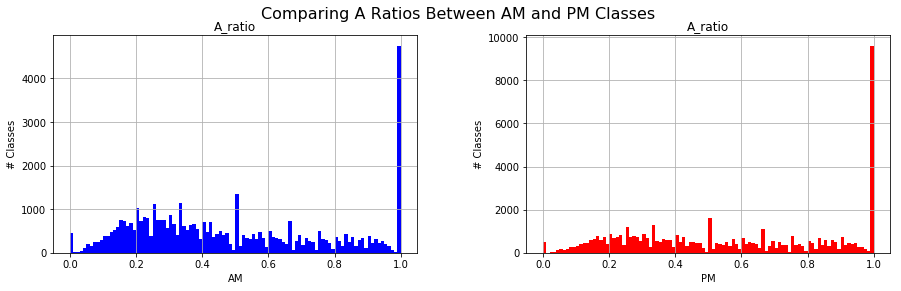

In [268]:
# Plotting the A_Ratios side by side to compare the AM vs PM classes

fig, axes = plt.subplots(1, 2,figsize = (15,4))

axes[0].set_title('AM')
axes[0].set_xlabel('AM')
axes[0].set_ylabel('# Classes')
axes[1].set_title('PM')
axes[1].set_xlabel('PM')
axes[1].set_ylabel('# Classes')
fig.suptitle('Comparing A Ratios Between AM and PM Classes', fontsize=16)

data_AM.hist('A_ratio', bins=100, ax=axes[0], color='b')
data_PM.hist('A_ratio', bins=100, ax=axes[1], color='r')

/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


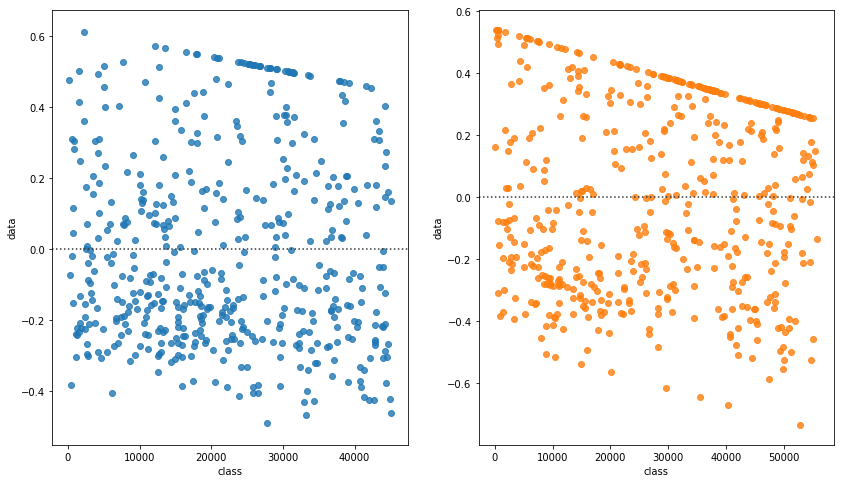

In [271]:

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns

xvalS=(range(len(data_AM)))
yvalS= list(data_AM.A_ratio)
df1 = pd.DataFrame({"class": xvalS, "data": yvalS})

xvalN=(range(len(data_PM)))
yvalN= list(data_PM.A_ratio)
df2 = pd.DataFrame({"class": xvalN, "data": yvalN})

dfSample1 = df1.sample(500) # This is the important line
dfSample2 = df2.sample(500) # This is the important line
xdataSample1, ydataSample1 = dfSample1["class"], dfSample1["data"]
xdataSample2, ydataSample2 = dfSample2["class"], dfSample2["data"]

#plt.show()
fig, ax =plt.subplots(1,2)
fig.set_size_inches(14, 8)
sns.residplot(x=xdataSample1, y=ydataSample1, ax=ax[0]);
sns.residplot(x=xdataSample2, y=ydataSample2, ax=ax[1]);

fig.show()

Residual Plot
A residual plot is a graph that shows the residuals on the vertical axis and the independent variable on the horizontal axis. If the points in a residual plot are randomly dispersed around the horizontal axis, a linear regression model is appropriate for the data; otherwise, a non-linear model is more appropriate.

Below, the residual plots show three typical patterns. The first plot shows a random pattern, indicating a good fit for a linear model.

### 2. Analyzing A's across the two populations
Insights regarding the data were already made in the first exercise, for this exercise, we will get statistics for the two populations, use the statistics to calculate the two sample t-test, and explore the null hypothesis vs the alternative hypothesis.

In [272]:
# getting statistics for the AM A_ratios
data_AM.A_ratio.describe()

count    45281.000000
mean         0.487667
std          0.289985
min          0.000000
25%          0.250000
50%          0.421000
75%          0.714000
max          1.000000
Name: A_ratio, dtype: float64

In [273]:
# getting statistics for the PM A_ratios
data_PM.A_ratio.describe()

count    55811.000000
mean         0.566653
std          0.307458
min          0.000000
25%          0.290000
50%          0.538000
75%          0.875000
max          1.000000
Name: A_ratio, dtype: float64

### 3. Comparing the A's Earned between AM and Not AM Classes
We choose to perform a two sample T-test, as these data are one continuous target (A ratio) and 1 categorical factor (2 levels - AM/Not AM) and we are looking to understand difference.

H0 = There is no difference in the A's earned in AM classes vs. PM (Not AM) classes.
HA = There is a difference in the A's earned in these populations.

alpha = 0.05

df = 101,090

In [274]:
# Calculating the t statistic in two ways:  the first with this method
import math
tNumerator = 0.487667-0.566653
tDenominator = math.sqrt(((0.289985**2)/45281)+((0.307458**2)/55811))
t= tNumerator/tDenominator
t

-41.916346901109215

In [276]:
# Calculating the t statistic in two ways:  the second with the stats ttest
stats.ttest_ind(data_AM.A_ratio,data_PM.A_ratio, equal_var = False)

Ttest_indResult(statistic=-41.91624944499381, pvalue=0.0)

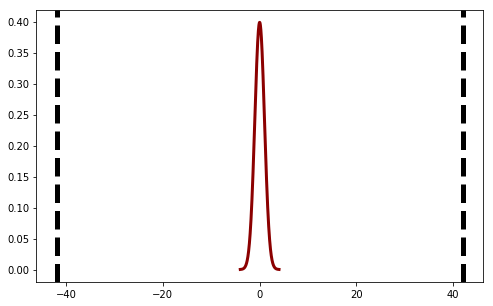

In [275]:
# Again, as learned in a lesson, plot the t statistic and the data probability of getting this information by chance

control = data_AM.A_ratio
experimental = data_PM.A_ratio
def visualize_t(t_stat, n_control, n_experimental):
    # initialize a matplotlib "figure"
    fig = plt.figure(figsize=(8,5))
    ax = fig.gca()
    # generate points on the x axis between -4 and 4:
    xs = np.linspace(-4, 4, 500)
    # use stats.t.pdf to get values on the probability density function for the t-distribution  
    ys= stats.t.pdf(xs, (n_control+n_experimental-2), 0, 1)
    ax.plot(xs, ys, linewidth=3, color='darkred')

    ax.axvline(t_stat, color='black', linestyle='--', lw=5)
    ax.axvline(-t_stat, color='black', linestyle='--', lw=5)

    plt.show()
    return None

n_control = len(control)
n_experimental = len(experimental)

control = data_AM.A_ratio
experimental = data_PM.A_ratio

visualize_t(-41.916236901109215,45281,55811)


### 4. Question 2 Conclusions
To assess whether there is a difference in the number of A's earned in morning (AM) courses vs afternoon/evening (PM) courses, we tested the "A ratio," which was the number of A's divided by the number of total grades for each class. Our AM courses included 45,281 classes and our PM courses included 55,811 classes.

Our Null Hypothesis (H0) was: There is no difference in the A's earned in AM classes (before 12:00) vs. PM (after 12:00) classes.

Our Alternative Hypothesis (HA) was: There is a difference in the A's earned in these populations.

Our analysis returned a t-statistic of -41.9 with a pvalue of 0.0, given 101,090 degrees of freedom.

Negative t-value: The sign of a t-value tells us the direction of the difference in sample means. The mean of our AM population was less than the mean of our PM population. In other words, on average, the A Ratio of AM classes was lower than that of PM courses by 7.9%.

Given the p-value of 0, and an alpha of 0.05, the data show we can reject the Null Hypothesis.
 
Thus, these data show there is a significant difference in the number of A's earned in AM classes vs. PM classes.